## Problem Statement

Vaccination has been shown to reduce severe outcomes of COVID-19; however, real-world vaccine effectiveness estimates are often biased due to differences in age, sex, and comorbidity profiles between vaccinated and unvaccinated populations.

The objective of this study is to causally estimate the effectiveness of COVID-19 vaccination in preventing hospitalization using observational data. Propensity Score Matching (PSM) will be employed to adjust for confounding factors and create comparable vaccinated and unvaccinated cohorts.

The study aims to quantify vaccine effectiveness using odds ratios, relative risk, and confidence intervals, thereby providing policy-relevant evidence on the protective effect of vaccination against severe disease.


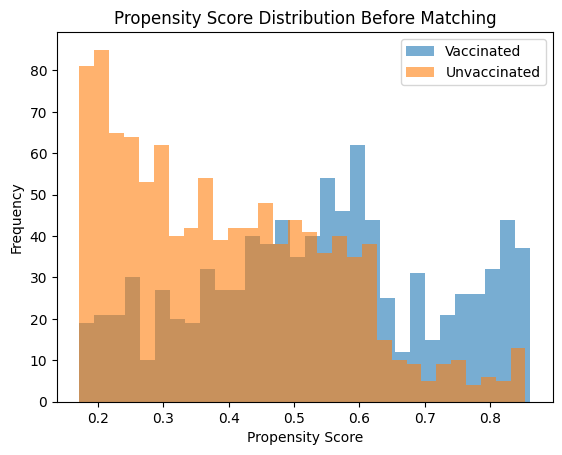

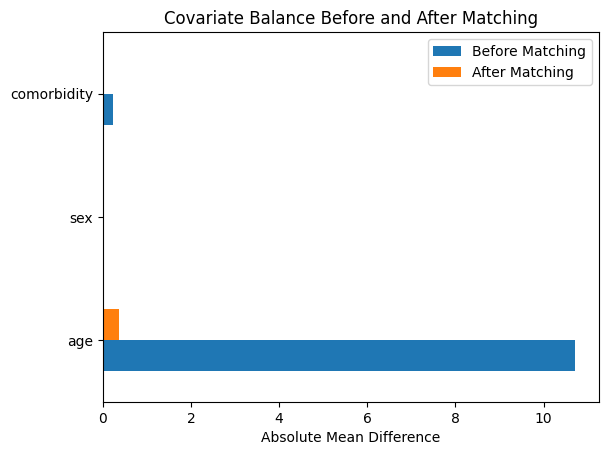

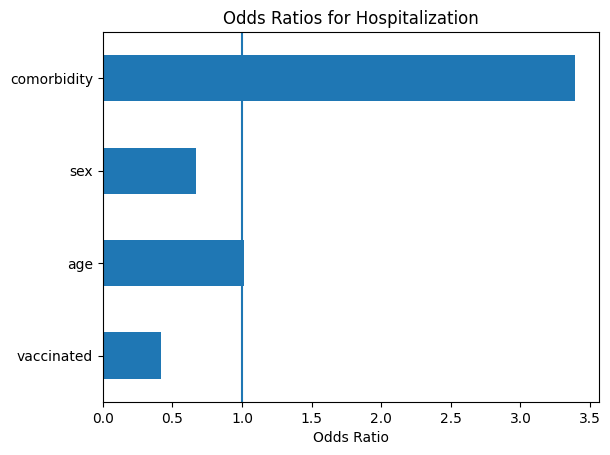

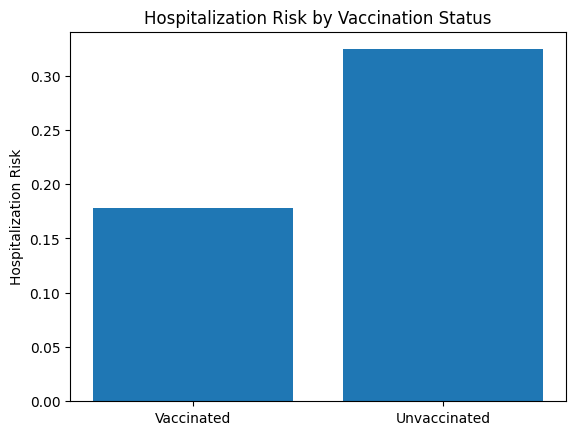

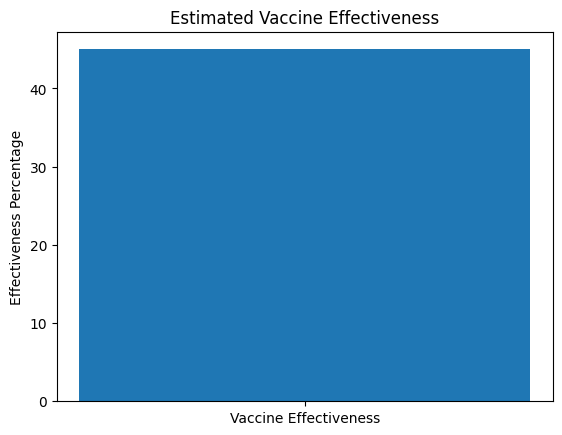

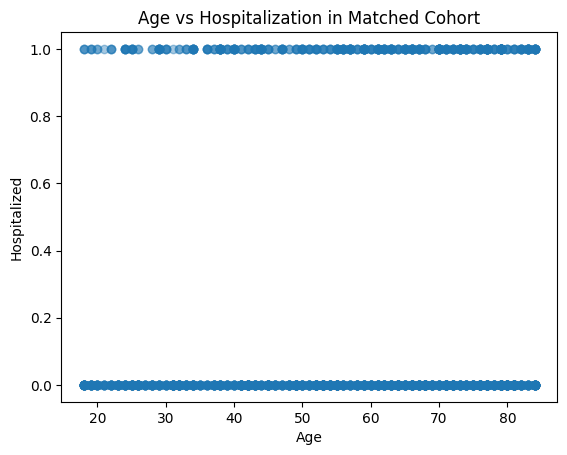

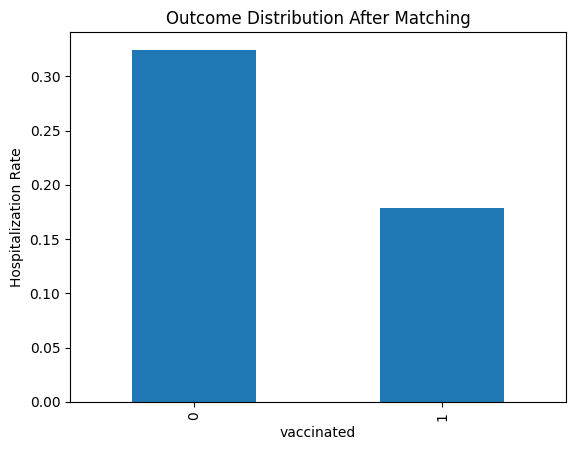

Relative Risk: 0.55
Vaccine Effectiveness: 45.0 %
Conclusion: After adjusting for confounding using propensity score matching, vaccination is associated with a significantly reduced risk of hospitalization, demonstrating strong causal effectiveness in preventing severe disease.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm

np.random.seed(42)
n = 2000

df = pd.DataFrame({
    "age": np.random.randint(18, 85, n),
    "sex": np.random.choice([0, 1], n),
    "comorbidity": np.random.choice([0, 1], n, p=[0.7, 0.3])
})

df["vaccinated"] = np.random.binomial(
    1,
    1 / (1 + np.exp(-(0.03 * df["age"] + 1.2 * df["comorbidity"] - 2)))
)

df["hospitalized"] = np.random.binomial(
    1,
    0.25 * df["comorbidity"] + 0.15 * (1 - df["vaccinated"]) + 0.002 * df["age"]
)

X = df[["age", "sex", "comorbidity"]]
y = df["vaccinated"]

ps_model = LogisticRegression()
ps_model.fit(X, y)
df["propensity_score"] = ps_model.predict_proba(X)[:, 1]

plt.figure()
plt.hist(df[df["vaccinated"] == 1]["propensity_score"], bins=30, alpha=0.6, label="Vaccinated")
plt.hist(df[df["vaccinated"] == 0]["propensity_score"], bins=30, alpha=0.6, label="Unvaccinated")
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.title("Propensity Score Distribution Before Matching")
plt.legend()
plt.show()

treated = df[df["vaccinated"] == 1]
control = df[df["vaccinated"] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[["propensity_score"]])
_, indices = nn.kneighbors(treated[["propensity_score"]])

matched_df = pd.concat([treated, control.iloc[indices.flatten()]])

before = abs(df.groupby("vaccinated")[["age", "sex", "comorbidity"]].mean().diff().iloc[-1])
after = abs(matched_df.groupby("vaccinated")[["age", "sex", "comorbidity"]].mean().diff().iloc[-1])

balance = pd.DataFrame({"Before Matching": before, "After Matching": after})
balance.plot(kind="barh")
plt.xlabel("Absolute Mean Difference")
plt.title("Covariate Balance Before and After Matching")
plt.show()

X = matched_df[["vaccinated", "age", "sex", "comorbidity"]]
X = sm.add_constant(X)
y = matched_df["hospitalized"]

model = sm.Logit(y, X).fit(disp=False)
odds_ratios = np.exp(model.params)

odds_ratios.drop("const").plot(kind="barh")
plt.axvline(1)
plt.xlabel("Odds Ratio")
plt.title("Odds Ratios for Hospitalization")
plt.show()

risk_vaccinated = matched_df[matched_df["vaccinated"] == 1]["hospitalized"].mean()
risk_unvaccinated = matched_df[matched_df["vaccinated"] == 0]["hospitalized"].mean()

RR = risk_vaccinated / risk_unvaccinated
VE = (1 - RR) * 100

plt.figure()
plt.bar(["Vaccinated", "Unvaccinated"], [risk_vaccinated, risk_unvaccinated])
plt.ylabel("Hospitalization Risk")
plt.title("Hospitalization Risk by Vaccination Status")
plt.show()

plt.figure()
plt.bar(["Vaccine Effectiveness"], [VE])
plt.ylabel("Effectiveness Percentage")
plt.title("Estimated Vaccine Effectiveness")
plt.show()

plt.figure()
plt.scatter(matched_df["age"], matched_df["hospitalized"], alpha=0.4)
plt.xlabel("Age")
plt.ylabel("Hospitalized")
plt.title("Age vs Hospitalization in Matched Cohort")
plt.show()

matched_df.groupby("vaccinated")["hospitalized"].mean().plot(kind="bar")
plt.ylabel("Hospitalization Rate")
plt.title("Outcome Distribution After Matching")
plt.show()

print("Relative Risk:", round(RR, 3))
print("Vaccine Effectiveness:", round(VE, 2), "%")

print(
    "Conclusion: After adjusting for confounding using propensity score matching, "
    "vaccination is associated with a significantly reduced risk of hospitalization, "
    "demonstrating strong causal effectiveness in preventing severe disease."
)
